In [165]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import sys
import pandas as pd
import datetime
import re
import nltk
from nltk import ne_chunk_sents, ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
# from stop_words import get_stop_words
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag

from collections import Counter
import operator

# supressing the INFO log messages while training the model below to keep notebook from being unresponsive
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/rshringi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Topic Modeling

This section is about unsupervised learning with text data.
We'll be using a relatively small dataset, consisting of 3430 documents and a vocabulary of 6906 words drawn from the daily kos blog around 2004. 

You can download the data [here](https://s3-eu-west-1.amazonaws.com/lastmilecoding/exercise.tar.gz).


## Bayesian mixture model

We're going to model the documents as bags of words, with a bayesian mixture model.
The documents are modeled using $K$ topics.
The assignment of a document to a topic is modeled by the latent variable $z_d$.

The topics are drawn from a categorical distribution with parameters $\theta$, where $\theta$ is drawn from a Dirichlet prior with parameter $\alpha$.

Each topic specifies a categorical distribution over words. The prior on each of these distributions is a Dirichlet with parameter $\gamma$. 


The figure below shows this in a graphical model.


![Graphical Model](http://i.imgur.com/AAGnKZ7.png)

For simplicity, let's denote with $y_n$ the observations (i.e. the documents we see in the corpus).
The conditional likelihood is:

$$p(y_n|z_n \negmedspace = \negmedspace k,\beta) = p(y_n|\beta_k) = p(y_n|\beta_{z_n})$$

And we have a prior:

$$p(\beta_k)$$

And a (latent) categorical assignment probability:

$$p(z_n \negmedspace= \negmedspace k|\theta) = \theta_k$$

which has a Dirichlet prior:

$$p(\theta|\alpha) = Dir(\alpha)$$

Which gives our latent posterior:

$$ p(z_n\negmedspace=\negmedspace k|y_n,\theta,\beta) \quad \propto p(z_n\negmedspace =\negmedspace k|\theta)p(y_n|z_n \negmedspace = \negmedspace k,\beta) \quad \propto \theta_k p(y_n|\beta_{z_n}) $$


### Gibbs Sampling
We will explore this model by drawing from the posterior using MCMC, specifically Gibbs sampling.

We will alternately sample the three types of variables, & iterate this procedure multiple times.

First we'll sample the component parameters:

$$p(\beta_k|y,z) \quad \propto p(\beta_k) \prod_{n:z_n=k} p(y_n|\beta_k) $$

Then the latent allocations of documents to topics:
$$ p(z_n \negmedspace= \negmedspace k|y_n,\theta,\beta) \quad \propto \theta_k p(y_n|\beta_{z_n})$$

and then the mixing proportions:

$$p(\theta|z,\alpha) = p(\theta|\alpha)p(z|\theta) = \mathrm{Dir}\left(\frac{c_k+\alpha_k}{\sum_j c_j + \alpha_j}\right)$$

where $c_k$ are the counts for mixture component $k$.

### The Collapsed Gibbs Sampler

We marginalise over $\theta$. (You do not need to derive this result).
N.B. the notation $c_{-n}$ indicates all indices _except_ $n$. 

$$p(z_n \negmedspace= \negmedspace k|z_{-n},\alpha) = \frac{\alpha + c_{-n,k}}{\sum_j \alpha + c_{-n,j}}$$

which gives the _collapsed_ gibbs sampler for the latent assignments:

$$p(z_n \negmedspace= \negmedspace k|y_n,z_{-n},\beta,\alpha) \propto p(y_n|\beta_k) \frac{\alpha + c_{-n,k}}{\sum_j \alpha + c_{-n,j}}$$

### Code

The documents have been split into two corpora, `A` and `B`.

The array `words` is a list of all the words in both corpora.
The matrices `A` and `B` are the train and test corpora, respectively. 
Each has 3 columns, there is one row for each unique word in each document.

The first column is the document index, second is the word index (corresponding to `words`), and the third is the number of times that word appears in the document. 

In [109]:
A = np.load('./data/mat_A.npy')
B = np.load('./data/mat_B.npy')
words = np.load('./data/words.npy')

W = np.max(np.hstack((A[:,1],B[:,1]))) + 1   # number of unique words
D = np.max(A[:,0]) + 1   # number of documents in A
K = 20 # number of mixture components we will use

alpha = 10  # parameter of the Dirichlet over mixture components
gamma = 0.1 # parameter of the Dirichlet over words

The function below defines the following matrices:
 * `sd` : the mixture component assignment of each document
 * `swk` : K multinomial distributions over W unique words
 * `sk_docs` : the number of documents assigned to each mixture component
 * `sk_words` : the number of words assigned to mix component `k` accross all docs
 
These are initialised by assigning each document to a mixture component at random.

In [116]:
def init():
    sd = np.floor(K*np.random.random((D,1))).astype(int)   
    swk = np.zeros((W,K))              
    sk_docs = np.zeros((K,1)) 

    for d in np.arange(D): 
        w = A[A[:,0]==d,1]      # unique words in doc d
        c = A[A[:,0]==d,2]      # counts
        k = sd[d]               # doc d is in mixture k
        swk[w,k] = swk[w,k] + c # num times word w is assigned to mixture component k
        sk_docs[k] = sk_docs[k] + 1

    sk_words = np.sum(swk,axis=0).T
    return sd, swk, sk_docs, sk_words

The following code starts from this initial state & then performs a number of gibbs sampling sweeps. 
We will use the collapsed Gibbs sampler, which uses the trick of excluding the current document's counts before calculating the posterior and resampling.


In [122]:
sd, swk, sk_docs, sk_words = init()
# This makes a number of Gibbs sampling sweeps through all docs and words
num_sweeps = 10
for i_sweep in np.arange(num_sweeps): 
    print("gibbs sweep : {0}".format(i_sweep))
    for d in np.arange(D):
        w = A[A[:,0]==d,1]      # unique words in doc d
        c = A[A[:,0]==d,2]      # counts

        # remove doc d's contributions from count tables
        swk[w,sd[d]] = swk[w,sd[d]] - c 
        sk_docs[sd[d]] = sk_docs[sd[d]] - 1 
        sk_words[sd[d]] = sk_words[sd[d]] - np.sum(c) 
        
        # log probability of doc d under each mixture component
        lb = np.zeros(K)    
        for k in np.arange(K):
            ll = np.dot(c,( np.log(swk[w,k]+gamma) - np.log(sk_words[k] + gamma*W) ))
            lb[k] = np.log(sk_docs[k] + alpha) + ll

        # assign doc d to a new component
        b = np.exp(lb-np.max(lb))  
        kk = sample_discrete(b)  

        # add back doc d's contributions from count tables
        swk[w,kk] = swk[w,kk] + c 
        sk_docs[kk] = sk_docs[kk] + 1 
        sk_words[kk] = sk_words[kk] + np.sum(c)
        sd[d] = kk        

gibbs sweep : 0
gibbs sweep : 1
gibbs sweep : 2
gibbs sweep : 3
gibbs sweep : 4
gibbs sweep : 5
gibbs sweep : 6
gibbs sweep : 7
gibbs sweep : 8
gibbs sweep : 9


In [121]:
# sd, swk, sk_docs, sk_words = init()

# print (sd, type(sd), sd.shape)
# print (swk[10], type(swk), swk.shape)
# print (sk_docs, type(sk_docs), sk_docs.shape, np.sum(sk_docs))
# print (sk_words, type(sk_words), sk_words.shape, np.sum(sk_words))

#### Understanding the helper function: sample_discrete()
- check and add comments

In [172]:
# The function below draws a sample from an unnormalised discrete distribution.
def sample_discrete(b):
# np.random.random() return random floats in the half-open interval [0.0, 1.0). Thus making r = [0.0, np.sum(b))
    r = np.sum(b)*np.random.random();
# copying the contents of first element of b into a
    a = b[0].copy()
    i = 0
# till a is less than the random value in r, update a as sum of a and next item in b, starting from b[1]
    while a < r:
        i += 1
        a += b[i]
    return i

# the loop exits when a becomes higher than r, it returns that index(i) of b where summation from 0 to i of b[] 
# becomes greater than the number r

# deductions: "i" is integer value < = len(b)-1 or (b.size - 1) and range for i = [0, len(b))

## Task 1 : 
1. **Explain what the code above does. Are you happy with this model? What are its deficiencies?**
 
**Answer:**: 
- Above code attempts to implement collapsed Gibb's sampler for LDA (latent Dirichlet Allocation).
- Given a corpus of documents as distribution of words it aims to achieve the task of Topic Modelling

**K** = 20 # number of Topics

**sd** : Each row corresponds to specific document and the value of topic that the specific document belongs to, ranges from 0-19 (no of topics => K = 20)
<br>One document is assigned to only one topic. ***However, ideally a document should have a distribution over topics***
<br>dimension : (No. of unique docs, 1 ) = (2000, 1)
 
**swk** : Distribution of K-topics for each word, over the entire corpus. 
<br> eg. [ 2.  3.  2.  0.  3.  1.  0.  1.  0.  0.  2. 14.  0.  5.  0.  0.  1.  0.  1. 11.]
<br> dimension : (No. of unique words, No. of topics ) = (6906, 20)

**sk_docs** : 20 entries one for each K topic, contains total no. of docs assigned per topic. 
<br>dimension : (No. of topics, 1 ) = (20, 1)
<br> np.sum(sk_docs) = Total number of documents, **implying that each document belongs to only one Topic.**

**sk_words** : 20 entries, one for each K topic. Shows number of words assigned to each topic over entire corpus. One word can be assigned to multiple topics.
<br> eg. [11984. 12039. 13412. 11942. 13266. 15652. 12111. 13249. 14146. 15024.12709. 14054. 16948. 13121. 11197. 13787. 13317. 15356. 15046. 13538.] 
<br>dimension : (No. of topics, ) = (20,)
<br>np.sum(sk_words) = 271898.0 > W ; **implying that one words belongs to one or more topics.**
 
<br> The ***init()*** function:
- Initialises vairables sd, swk, sk_docs, sk_words at random. 
- It begins by generating random numbers in range (0,1]*K for total no of documents(D) in train set, and initializes swk, sk_docs as numpy arrays filled with zeros. 
- Then it iterates over every document in range (0..D) and performs word count and topic count based on initial random distribution in sd.

- w = A[A[:,0]==d,1] ; iterates over A, looks for all the (unique)words with the document_id 'd' and stores their word_index in w
- c = A[A[:,0]==d,2]; iterates over A, looks for all the (unique)words with the document_id 'd' and stores their count in c 
- k = sd[d]; get the random topic assigned to document d
- swk[w,k] = swk[w,k] + c ; Update the value of specific word count with the specific topic
- sk_docs[k] = sk_docs[k] + 1 ; Increase the document associated with the topic 'k' by one
- sk_words = np.sum(swk,axis=0).T; Gets the column wise sum in swk matrix to get sum of words per topic. 

<br> Now we **train** this model by Gibb's sampling technique. The algorithm works as follows:
- we predefine no. of times Gibbs sampling is performed
- for each iteration of Gibb's sampling, iterate over the each document in corpus.
- we first calculate the contribution of words and topics for this document "d" and remove it from the matrices swk, sk_words, sk_docs. 
- The **idea** is to remove the contribution of document "d" and then re-sample it's contribution assuming that the contribution from all other documents stay fixed in swk, sk_words, sk_docs.
**Resample the contribution of a document "d" given these existing data/matrices which acts as a Prior.**
<br>

- log probability of document "d" for belonging to a topic "K" is then calculated via iteration over each topic. 
- Variable "ll" calculates the dot product of "c" count of all uniques words with a log(fraction). The fraction represents probability of a specific word belonging to a specific topic, this includes the dirichlet coefficients acting as smoothing factors in case of values going to zero.

- variable "b" represents the probablity distribution of document "d" to belong to "K" topics. [0..19]
- kk = sample_discrete(b) returns an integer from range [0, 20) indicating the new topic doc "d" belongs to

- once we have new topic "kk", we update the contribution of doc "d" throughout the matrices swk, sk_words, sk_docs and repeat the iteration for next documents

- Although we start with random values but over a period of time (say after N sweeps - we forget the intialization if we run the sampler long enough) the values stabilize to give good co-relation between the calculated values in swk, sk_words, sk_docs with the observation (training data).  

***Deficiences:*** 
<br>
- Each document (data in **sd**) is assigned only one Topic while it ideally should be a distribution over k-topics similar to as the words are associated with multiple topics in **swk**.

- Above algorithm is sampling a new(single) topic once we have re-sampled topic distributions for a specific document:<br>
**kk = sample_discrete(b)**

This returns a single number between [0,20) but is not stable and gives different values on subsequent runs.

- Running on test data to infer new topic for say document zero of set B, call to sample_discrete(b) gives different topic assignment on subsequent runs with the fixed input "b" - topic distribution of document


**Suggestions:**
<br> (pseudocode)
- **Iterate** for each document in corpus:
    - for each word in document:
        - reset it's contribution(count) values from topic-word distribution matrix and document-topic matrix accordingly
        - based on values in word-topic matrix and document-topic matrix, recalculate two probabilities to represent: **how much each Topic likes this word** and **how much this document likes a specific topic**
        - Product of above two quantities gives us the probaility distribution of the specific word with topics, the most probable topic can become a **new topic assignment** of this word. 
        - update the conribution of the word in topic-word distribution matrix and document-topic matrix
        - repeat


### Task 1:
**2. Calculate the log probability of the first document in corpus B. What does this number mean?**
<br>**Ans:**
<br> I have calculated below the log probability of the first document in corpus B **under each mixture model**. This number shows the log probability value **distribution(numbers do NOT add up to 1)** of topics for first document in corpus B based on the, word-topic distribution and doc-topic distribution learnt during training through Gibbs sampling.  

In [130]:
#  log probability of the first document in corpus B under each mixture model
d = 0
K = 20
w = B[B[:,0]==d,1]      # unique words in doc d
c = B[B[:,0]==d,2]      # counts

# log probability of doc d under each mixture component
lb = np.zeros(K)    
for k in np.arange(K):
    ll = np.dot(c,( np.log(swk[w,k]+gamma) - np.log(sk_words[k] + gamma*W) ))
    lb[k] = np.log(sk_docs[k] + alpha) + ll

# assign doc d to a new component
b = np.exp(lb-np.max(lb))  
kk = sample_discrete(b)

print (b)
print (kk)

[0.41532258 0.04233871 0.125      0.29032258 0.04637097 0.03629032
 0.77016129 0.07862903 0.3266129  0.50806452 0.13104839 0.05645161
 0.0483871  0.03830645 0.27217742 1.         0.08064516 0.05040323
 0.02822581 0.09072581]
9


### Task 1
**3. Calculate the per-word perplexity of the test corpus. What does this number mean? Is it good?**

- What does this number mean?
<br> Perplexity, is an intrinsic way of evaluation of any language model(over here our Topic model). It's based on the idea that given the specific model parameteres how likely is to observe the given document/corpus. Also known as hold one out test(where test set is kept separate and is not used in training the model).
<br> The higher the log likelihood of unseen documents the better the model. Preplexity is computed as the decreasing function of log likelihood of unseen documents. Thus the lower the perplexity the better the model.
<br> 
- On reading more about perplexity computation, I did get to know about methods such as LR:Left-to-right. CS: Chib-style but couldn't implement them in given time.
<br> Sources : http://dirichlet.net/pdf/wallach09evaluation.pdf
<br> http://qpleple.com/perplexity-to-evaluate-topic-models/

### Inferences :
- Retrieving **top word distributions for each Topic** for above model 
- Using external libraries to perform topic modelling on **this data-set (mat_A.npy)**
- https://pythonhosted.org/lda/
- https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel

In [135]:
for k in range(0,20):
    swk_T = swk.T
    print ("Topic %s:" % k, end =" ")
    topic_wordIndices = np.argsort(swk_T[k])[::-1][:10]
    for word_id in topic_wordIndices:
        print (words[word_id], end =" ")
    print()

Topic 0: november poll house bush senate republicans kerry polls governor electoral 
Topic 1: senate republicans democrats investigation subpoena grand records federal law subpoenas 
Topic 2: nader ballot voters general republican bunning election state party voter 
Topic 3: bush kerry poll voters percent polls general president election polling 
Topic 4: bush kerry endorsement papers general oct news president editorial newspaper 
Topic 5: endorsement afscme unions dean labor seiu candidate union democratic clark 
Topic 6: kerry bush democratic campaign dean party media democrats edwards general 
Topic 7: bush kerry service guard records national military texas bushs kerrys 
Topic 8: bush president administration tax kerry republicans states jobs house people 
Topic 9: senate race house republican elections democratic state democrats percent district 
Topic 10: kerry bush poll results general polls pdf surveyusa percent voters 
Topic 11: delay committee house ethics texas democrats re

In [136]:
# transforming data in the form ingestible by downstream LDA model

X = np.zeros((D, words.size), dtype=int) # initialise a document-term matrix

# Transforming the train set A in X(document-term matrix) where each row represents a document with counts of words in column, where 
# column number corresponds to word_index as stored in vocabulary @words

for d in np.arange(D):
    w = w = A[A[:,0]==d,1]      # unique words in doc d
    c = A[A[:,0]==d,2] 
    for word_id in np.arange(len(w)):
        X[d,w[word_id]] = int(c[word_id])

In [138]:
# https://pythonhosted.org/lda/
# lda implements latent Dirichlet allocation (LDA) using collapsed Gibbs sampling.

import lda
vocab = words

model = lda.LDA(n_topics=20, n_iter=2000, random_state=1)
model.fit(X)  # model.fit_transform(X) is also available
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: people america time american years political white
Topic 1: poll bush kerry percent polls voters polling
Topic 2: november senate account governor electoral polls vote
Topic 3: states state voters nader vote election general
Topic 4: administration house bush officials white commission information
Topic 5: november turnout exit west poll trouble parecommend
Topic 6: iraq war bush administration united states american
Topic 7: november voting general election planned soldier republicans
Topic 8: media news ill blog press bloggers read
Topic 9: senate campaign john bunning senator clinton news
Topic 10: party democrats republican republicans democratic delay committee
Topic 11: policy blades meteor reagan human research rights
Topic 12: campaign money candidates million house race raised
Topic 13: time people hard political election put matter
Topic 14: dean edwards kerry primary democratic clark iowa
Topic 15: law court bush national marriage state gay
Topic 16: iraq war iraqi 

loglikelihood value: -2173745.586473
perplexity value: 314.761886
It can be observed that the loglikelihood value stabilizes over a period of time.


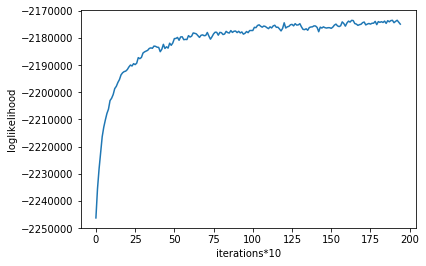

In [145]:
print ("loglikelihood value: %f" % (model.loglikelihood()))

log_perplexity =  (-1 * (model.loglikelihood()/len(vocab)))
print ("perplexity value: %f" % (log_perplexity))

plt.xlabel("iterations*10")
plt.ylabel("loglikelihood")
plt.plot(model.loglikelihoods_[5:])

print ("It can be observed that the loglikelihood value stabilizes over a period of time.")

In [157]:
# transforming train set A into format to be used by Gensim

#  each row of LIST X_corpus(document-term matrix) contains (word_id,count) where word_id is the identifier for a word in vocabulary
#  count is the number of times that word appears in document

X_corpus = [] 

# Transforming the train set A in X where each row represents a document with counts of words in column, where 
# column number corresponds to word_index as stored in vocabulary @words

for d in np.arange(D):
    w = w = A[A[:,0]==d,1]      # unique words in doc d
    c = A[A[:,0]==d,2]
    X_corpus.append(zip(w,c))
    
id2word = dict(enumerate(words.flatten(), 1))

In [746]:
import gensim
lda_model = gensim.models.ldamodel.LdaModel(corpus=X_corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

In [747]:
# Print the Keyword in the 20 topics
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[X_corpus]

# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(X_corpus))  # a measure of how good the model is. lower the better.



[(0,
  u'0.035*"bus" + 0.019*"millers" + 0.018*"jobless" + 0.015*"presidency" + 0.015*"tauzin" + 0.015*"admin" + 0.014*"bushrove" + 0.013*"economists" + 0.012*"bill" + 0.012*"echoed"'),
 (1,
  u'0.012*"polish" + 0.007*"tim" + 0.007*"year" + 0.007*"metaphor" + 0.007*"blackwell" + 0.006*"proceed" + 0.006*"cent" + 0.006*"pentagons" + 0.006*"calistan" + 0.006*"confederate"'),
 (2,
  u'0.086*"dealt" + 0.076*"edward" + 0.063*"primarily" + 0.050*"kerrey" + 0.050*"democrat" + 0.041*"clarify" + 0.031*"involving" + 0.026*"gep" + 0.025*"liebeck" + 0.016*"candidate"'),
 (3,
  u'0.024*"camp" + 0.012*"tim" + 0.010*"pentagons" + 0.009*"shown" + 0.008*"harbor" + 0.007*"climate" + 0.007*"toll" + 0.007*"mess" + 0.007*"jindal" + 0.007*"weekly"'),
 (4,
  u'0.069*"novak" + 0.014*"hours" + 0.014*"governments" + 0.014*"accomplishment" + 0.014*"elections" + 0.013*"politics" + 0.013*"sen" + 0.013*"republican" + 0.012*"polling" + 0.010*"volunteers"'),
 (5,
  u'0.047*"sen" + 0.032*"spectacular" + 0.028*"oath" + 

## Task 2:

In this part, you will do **topic modeling on New York Times corpus**. You can download the corpus from here
(https://www.kaggle.com/nzalake52/new-york-times-articles) . This part is free style, please show us what you got
library is welcomed, in particlar we are happy to see
- Sequential models
- Respecting the document hierarchy, organization into sentences and paragraphs
- Different sorts of attention

### Data input and preprocessing :

- before beginning with topic modelling, parsing the input and applying following **pre-processing**:
    - remove the **URL** from each article as it will not add any value after tokenisation
    - tokenisation, stop word removal
    - proper noun(s) removal, as they will not provide additional value 

In [3]:
#Reading the news articles file

nyTimesFile = open('new-york-times-articles/nytimes_news_articles.txt')
nyTimesFile.seek(0)
nyTimesV1 = nyTimesFile.readlines()
nyTimesArticles = []
nyTimesURL = []

# collecting and removing the URLs into a separate list 
for i in range(0, len(nyTimesV1)-1):
    if re.findall('URL', nyTimesV1[i]) == []:
        sent = sent + nyTimesV1[i]
        if (re.findall('URL', nyTimesV1[i+1]) != []) and (i+1 < len(nyTimesV1)):
            nyTimesArticles.append(sent.strip())
    else:
        sent = ''
        nyTimesURL.append(nyTimesV1[i])

In [11]:
stop_words = stopwords.words('english')
stop_words_caps = [word.title() for word in stop_words]
# generating list of stop_words with title case to be removed from text as well
stop_words.extend(stop_words_caps)

# Here I define a tokenizer and stopword removal function
# It returns individual tokens for each article after removing stop words

def tokenize_and_stopWordsRemoval(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation) and words whose 
    # length is less than 2 characters - removes some of the uncatched stopwords  
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2 and token not in stop_words :
            filtered_tokens.append(token)
    return filtered_tokens

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
def strip_proppers_POS(text):
    tagged = pos_tag(text) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

print ("#### BEFORE preprocess article contents : ")
print (nyTimesArticles[0][:100])

#tokenize
%time tokenized_text = [tokenize_and_stopWordsRemoval(text) for text in nyTimesArticles]

print ("##### done with tokenisation and stop word removal. After article contents :")
print (tokenized_text[0][:10])

#### BEFORE preprocess article contents : 
WASHINGTON — Stellar pitching kept the Mets afloat in the first half of last season despite their of
##### done with tokenisation and stop word removal. After article contents :
['WASHINGTON', 'Stellar', 'pitching', 'kept', 'Mets', 'afloat', 'first', 'half', 'last', 'season']


In [7]:
%time processed_text = [strip_proppers_POS(text) for text in tokenized_text]

CPU times: user 2min 49s, sys: 91.7 ms, total: 2min 49s
Wall time: 2min 50s


In [168]:
# Sanity Check : check the difference in list contents after removing proper nouns
# diff() method prints the tokens removed after strip_proppers_POS() function call

def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

print ("Tokens removed after removing Proper Nouns for Article 0:")
print (diff(tokenized_text[0],processed_text[0]))

print()
print ("Tokens removed after removing Proper Nouns for Article 1:")
print (diff(tokenized_text[1],processed_text[1]))

Tokens removed after removing Proper Nouns for Article 0:
['WASHINGTON', 'Stellar', 'Manager', 'Terry', 'Wednesday', 'Wednesday', 'Washington', 'Nationals', 'Steven', 'Matz', 'Logan', 'Verrett', 'Max', 'Scherzer', 'Nationals', 'James', 'Loney', 'Nationals', 'Shawn', 'Kelley', 'Nationals', 'National', 'League', 'East', 'Curtis', 'Granderson', 'Scherzer', 'Granderson', 'Granderson', 'Scherzer', 'Alejandro', 'Aza', 'Scherzer', 'Asdrubal', 'Cabrera', 'Loney', 'Brandon', 'Nimmo', 'Nimmo', 'Granderson', 'Travis', 'Arnaud', 'Aza', 'General', 'Manager', 'Sandy', 'Alderson', 'Earlier', 'May', 'June', 'Verrett', 'Daniel', 'Murphy', 'Addison', 'Reed', 'Jeurys', 'Familia', 'Sean', 'Gilmartin', 'Gilmartin', 'Murphy', 'Verrett', 'Verrett', 'Verrett', 'Wednesday', 'Matz', 'Noah', 'Syndergaard', 'Syndergaard', 'Matz', 'Thursday', 'Chicago', 'Cubs']

Tokens removed after removing Proper Nouns for Article 1:
['Mayor', 'Bill', 'Blasio', 'Maya', 'Wiley', 'City', 'Hall', 'Complaint', 'Review', 'Board', 'Ne

In [12]:
# Remove capitalization
%time processed_text_lower = [[word.lower() for word in x] for x in processed_text]

CPU times: user 386 ms, sys: 56 ms, total: 442 ms
Wall time: 441 ms


### LDA Topic Model :
- using **Gensim's** implementation of online LDA
- Online Latent Dirichlet Allocation (OLDA) models as presented by Hoffman, Blei, Bach: Online Learning for Latent Dirichlet Allocation, NIPS 2010.
- https://radimrehurek.com/gensim/models/ldamodel.html

In [143]:
from gensim import corpora, models
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(processed_text_lower)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in processed_text_lower]

In [16]:
%time lda_v1 = models.LdaModel(corpus, num_topics=10,id2word=dictionary,update_every=5,chunksize=10000,passes=50)
lda_v1.show_topics()

[(0,
  '0.016*"said" + 0.011*"company" + 0.010*"percent" + 0.007*"would" + 0.007*"million" + 0.007*"year" + 0.006*"companies" + 0.005*"last" + 0.005*"also" + 0.005*"billion"'),
 (1,
  '0.012*"said" + 0.008*"like" + 0.007*"one" + 0.006*"show" + 0.005*"new" + 0.004*"also" + 0.004*"first" + 0.004*"people" + 0.004*"time" + 0.004*"would"'),
 (2,
  '0.028*"said" + 0.007*"police" + 0.007*"case" + 0.007*"law" + 0.007*"court" + 0.006*"students" + 0.005*"school" + 0.005*"one" + 0.005*"also" + 0.004*"would"'),
 (3,
  '0.016*"said" + 0.012*"would" + 0.008*"campaign" + 0.005*"party" + 0.005*"could" + 0.005*"people" + 0.005*"political" + 0.005*"state" + 0.004*"president" + 0.004*"one"'),
 (4,
  '0.016*"said" + 0.008*"like" + 0.008*"one" + 0.005*"people" + 0.004*"would" + 0.004*"time" + 0.003*"years" + 0.003*"get" + 0.003*"back" + 0.003*"could"'),
 (5,
  '0.028*"said" + 0.009*"government" + 0.008*"people" + 0.006*"officials" + 0.005*"country" + 0.005*"military" + 0.005*"one" + 0.004*"security" + 0.00

#### Training OLDA with **multicore** support
- Change the **number of topics = 20**, keeping other parameters same as lda_v1

In [21]:
from gensim.models import LdaMulticore

num_topics = 20

dictionary_mlda = corpora.Dictionary(processed_text_lower)

# filter out words that appear in 30 documents or less,
# or in more than 70% of documents
dictionary_mlda.filter_extremes(no_below=30, no_above=0.7)

corpus_mlda = [dictionary_mlda.doc2bow(doc) for doc in processed_text_lower]

%time lda_v2 = LdaMulticore(corpus_mlda, id2word=dictionary_mlda, chunksize=10000,passes=50,workers=4, num_topics=num_topics)

CPU times: user 51min 6s, sys: 1min 50s, total: 52min 56s
Wall time: 22min 21s


In [99]:
from gensim.models import CoherenceModel
"""
Function to get the top word distribution across the topics
Calculate model Perplexity and Coherence score

Parameters
        ----------
        lda_model : gensim models.LdaModel
            The trained LdaModel
        corpus : list
            bag of words corpus for reference
        dictionary : key-value pairs
            Dictionary – a mapping between words and their integer ids
 """

def get_topics(lda_model, num_topics):
    topics_matrix = lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=20)
    topics_matrix = np.array(topics_matrix)

    topic_words = topics_matrix[:,1]
    count = 0
    for i in topic_words:
        print('Topic {%d}:' % count),
        print(" ".join([str(word[0]) for word in i]))
        count += 1
        print()    
    
def evaluate_topic_model(lda_model, corpus, dictionary, text):
    # Compute Perplexity
    print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is, lower the better.
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=text, dictionary=dictionary, coherence='c_v')
    print ("Pipeline parameters for C_V coherence")
    print (coherence_model_lda)
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

In [105]:
# check the topic-word distribution and perplexity scores for the above two LDA models

get_topics(lda_v1, 10)

evaluate_topic_model(lda_v1, corpus, dictionary, processed_text_lower)

Topic {0}:
said company percent would million year companies last also billion new business years could financial money executive one market chief

Topic {1}:
said like one show new also first people time would work years music last world film way two even year

Topic {2}:
said police case law court students school one also would two federal public years state lawyer last people officers investigation

Topic {3}:
said would campaign party could people political state president one vote also voters even like many support election percent think

Topic {4}:
said like one people would time years get back could two day family make even first home around way many

Topic {5}:
said government people officials country military one security two also group american last killed would many war attacks police city

Topic {6}:
said health cancer study drug people one patients care medical many drugs research doctors found years would could also scientists

Topic {7}:
fashion designer said like wear c

In [104]:
get_topics(lda_v2, 20)
evaluate_topic_model(lda_v2, corpus_mlda, dictionary_mlda, processed_text_lower)

Topic {0}:
would law also could financial court board money decision government last company legal new bank case million whether deal executive

Topic {1}:
first father graduated year also couple two son last received mother race married bride daughter second groom met time tennis

Topic {2}:
like show would time first also new people film think years way story work know even book life two music

Topic {3}:
government country military officials american would also security war political people last forces group two countries president minister foreign attacks

Topic {4}:
art work artists museum million artist works exhibition show collection director gallery new auction contemporary pieces also year design sale

Topic {5}:
school students schools city children water people year many education student public residents state high parents fire black college local

Topic {6}:
people family gay police man killed gun shooting mother told would two son transgender night attack died home group

### Inference : lda_v1 v/s lda_v2
- **Coherence Score**(C_V coherence) improves from 0.40 to 0.50, on increasing **num_topics to 20** 

### Latent Dirichlet allocation using Collapsed Gibb's Sampling:
- https://pythonhosted.org/lda/api.html
- Another external library with an implementation of Collapsed Gibb's Sampling for LDA
- Different set of perplexity score can be seen
- It can also be seen that the model converges after around 1000 iterations

In [24]:
# convert the existing preprocessed text into list of article strings
# To be provided as input to CountVectorizer

concat_article = [' '.join(article) for article in processed_text_lower]
concat_corpus = ' '.join(concat_article)

In [149]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(max_df=0.8, max_features=55000, min_df=50)

doc_term_matrix = vec.fit_transform(concat_article)
vocab = vec.get_feature_names()

In [147]:
import lda

"""Latent Dirichlet allocation using collapsed Gibbs sampling

Parameters:
    --------
    n_topics : int

        Number of topics

    n_iter : int, default 2000

        Number of sampling iterations

    alpha : float, default 0.1

        Dirichlet parameter for distribution over topics

    eta : float, default 0.01

        Dirichlet parameter for distribution over words

    random_state : int or RandomState, optional

        The generator used for the initial topics.
"""

model = lda.LDA(n_topics=20, n_iter=1000, random_state=1)

model.fit(doc_term_matrix)

/home/rshringi/anaconda3/envs/py3/lib/python3.7/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


Topic 0: said game first two season games second three team last run series hit one
Topic 1: food like restaurant also wine make day com recipe one water cooking chef chicken
Topic 2: said city two building one room house home three area new space also years
Topic 3: campaign said party voters election would presidential vote state political democratic candidate primary percent
Topic 4: would said law court state federal could case legal decision government bill rules rights
Topic 5: said company companies new like technology people also online business industry service customers use
Topic 6: said people military officials killed attacks group attack security fire government two city gun
Topic 7: art said work fashion museum like artist artists collection one works show first designer
Topic 8: said government country would political president american also countries european world new foreign minister
Topic 9: said team players year last first two sports game one player top play round


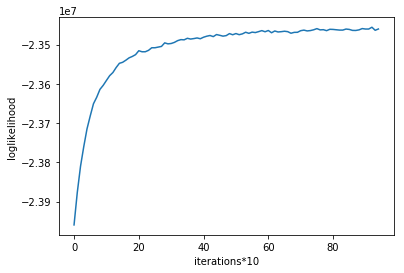

In [150]:
def get_topic_description(model, vocab):
    topic_word = model.topic_word_  # model.components_ also works
    n_top_words = 15
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
        print('Topic {}: {}'.format(i, ' '.join(topic_words)))

    print ("Model loglikelihood value: %f " % model.loglikelihood())
    
    plt.xlabel("iterations*10")
    plt.ylabel("loglikelihood")
    plt.plot(model.loglikelihoods_[5:])
    
get_topic_description(model, vocab)

print ("It can be observed that the loglikelihood value stabilizes over a period of time.")

### Grid Search for best parameter search:
- Using sklearn **GridSearchCV** to search for over parameter space on  **LatentDirichletAllocation** model. 

In [107]:
# source : https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(doc_term_matrix)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

/home/rshringi/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [108]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_term_matrix))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 20}
Best Log Likelihood Score:  -7285582.394132242
Model Perplexity:  2161.615129623764


### Inference:
- It's evident sklearn's LatentDirichletAllocation model is NOT achieving comparable results to gensim's OLDA
    - max_iterations = 10 while GridSearch params could be the main reason
    - due to limited time and computation resources, can not set high value for this parameter 
- Hoever both models agree on number of topics = 20

### Hierarchical Dirichlet Process
- Evaluate ***Hierarchial Dirichlet Process*** model available in Gensim
- The core estimation code is directly adapted from the blei-lab/online-hdp from Wang, Paisley, Blei: “Online Variational Inference for the Hierarchical Dirichlet Process”, JMLR (2011).
https://radimrehurek.com/gensim/models/hdpmodel.html

In [151]:
from gensim.models import HdpModel
# split the corpus in test and train set : 20%-80%
# ideally should be done random shuffle
train_len = int(0.8 * len(corpus_mlda))
hdp_corpus_train = corpus_mlda[:train_len]
hdp_corpus_test = corpus_mlda[train_len:]

hdp_model = HdpModel(hdp_corpus_train, id2word=dictionary_mlda, chunksize=10000)

In [153]:
# checking the topic-word distribution
get_topics(hdp_model, 20)

Topic {0}:
would like people also could two years first even including considerably last time state back many anxiety southeast seen voters

Topic {1}:
would last year like bride since also lawyers people years two time company merely collecting new could percent trouble comic

Topic {2}:
would like people shaping new mother symptoms time also two shots magna instrument first rifle many last worldwide single-family even

Topic {3}:
would fun like tables injured last weekend emotionally first version prosecutors also people workout could bullying outset rolled years million

Topic {4}:
airports like consequence people openness prohibiting rubber wheels also group sex numerous figure assess rising removal mortgages years less allied

Topic {5}:
would facing last many years people playwright prevent services practice culture space also could underwent much client like post urban

Topic {6}:
boards would reserved improvement witty picnic charts like people change cookingcare way also comme

In [154]:
# The value of total likelihood obtained by evaluating the model for all documents in the test corpus
likelihood = hdp_model.evaluate_test_corpus(hdp_corpus_test)
# log_perplexity = (-1 * (likelihood/len(vocab)))
log_perplexity = (-1 * (likelihood/len(dictionary_mlda)))

In [155]:
print ("Values for loglikelihood: %f, log_perplexity: %f " % (likelihood, log_perplexity))

Values for loglikelihood: -4803594.303194, log_perplexity: 490.062671 


### Inference :
- On inspection the topics generated by Hierarchial Dirichlet Process model appear to be overlaping
- **Topic-word distributions** are not as orthogonal and meaningful when compared to OLDA models v1 and v2 above 

In [94]:
%%time
from pyLDAvis import sklearn as sklearn_lda
from pyLDAvis import gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
# vis = gensim.prepare(lda_v1, corpus, dictionary)
vis

/home/rshringi/anaconda3/envs/py3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 57.7 s, sys: 1.34 s, total: 59.1 s
Wall time: 22min 32s
